<a href="https://colab.research.google.com/github/19WH1A0501/Stock-Prediction-Using-LSTM-and-ML-Methods/blob/main/1_final_major_wipro_CNN_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install tensorflow 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

In [ ]:
#Read the csv file
df = pd.read_csv('/content/drive/MyDrive/major datasets /Wipro_Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-03-01,219.600052,220.575058,218.400055,219.375061,214.714905,5447711,0.272727,3,11
1,2018-03-05,220.200058,220.312561,217.350052,218.212555,213.577072,4998325,0.000000,0,9
2,2018-03-06,218.437561,218.962555,214.612549,215.212555,210.640808,6302115,0.142857,1,7
3,2018-03-07,216.337555,218.137558,213.225052,214.012558,209.466324,2434170,0.400000,2,5
4,2018-03-08,214.837555,215.812546,212.362549,213.900055,209.356201,2693676,1.000000,2,2
...,...,...,...,...,...,...,...,...,...,...
1228,2023-02-21,407.399994,408.000000,402.100006,402.750000,402.750000,2880586,-0.252747,-46,182
1229,2023-02-22,399.500000,400.350006,394.450012,395.149994,395.149994,3441686,-0.237705,-29,122
1230,2023-02-23,395.799988,398.700012,393.399994,393.950012,393.950012,3039161,-0.238095,-15,63
1231,2023-02-24,395.950012,396.500000,392.549988,393.299988,393.299988,2553317,0.000000,0,29


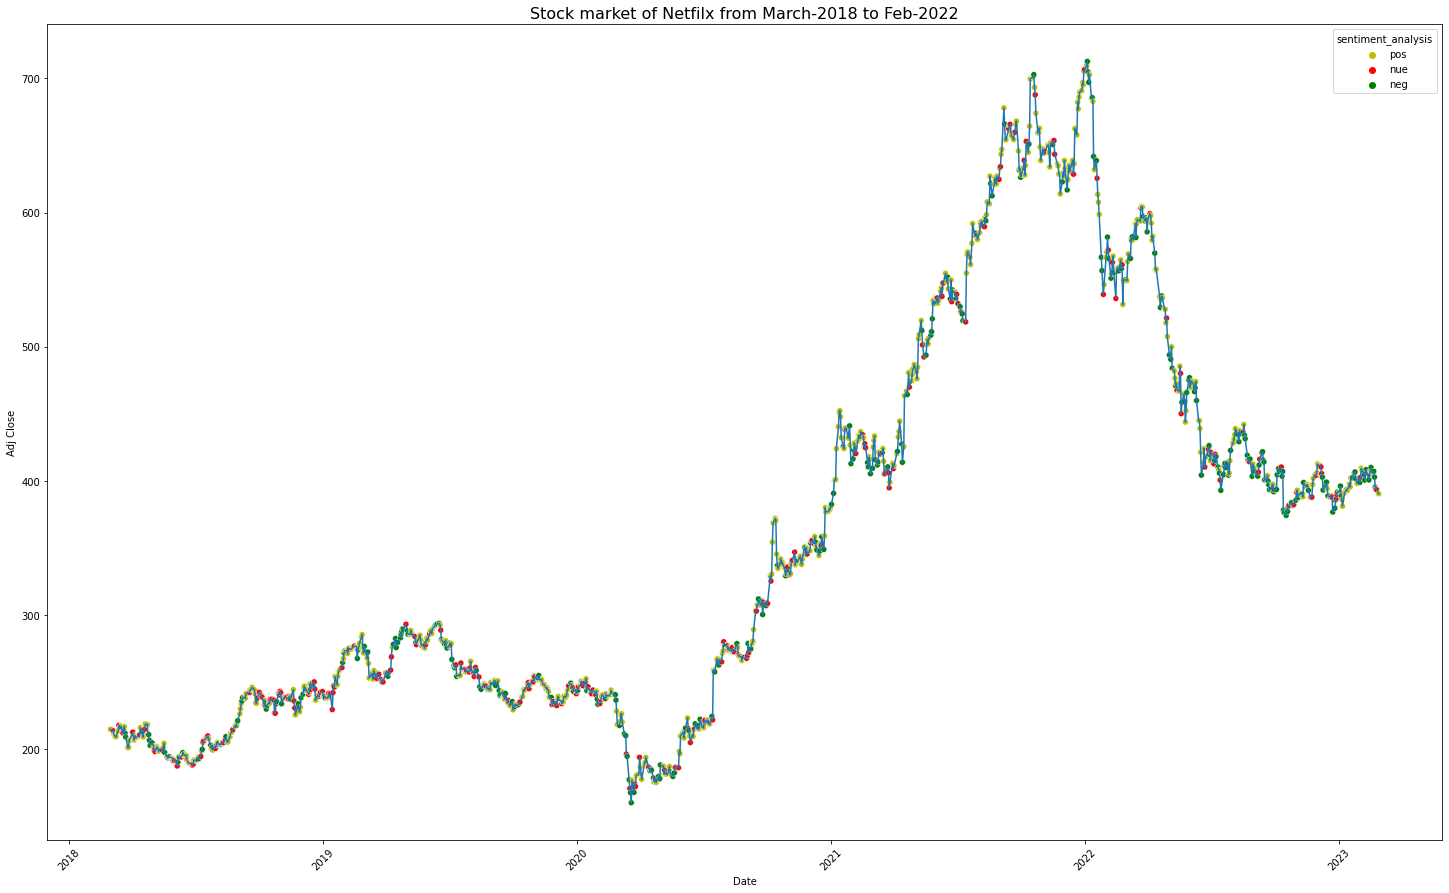

In [ ]:
import seaborn as sns
plt.figure(figsize=(25,15));
sns.lineplot(x=df["Date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["Date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netfilx from March-2018 to Feb-2022",fontsize=16);

In [ ]:
df['sentiment_analysis'].value_counts()

pos    590
neg    367
nue    276
Name: sentiment_analysis, dtype: int64

In [ ]:
train_dates = pd.to_datetime(df['Date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['Date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean', 'twt_count']


,Open,High,Low,Close,Volume,Adj Close,P_mean,twt_count
Date,,,,,,,,
2018-03-01,219.600052,220.575058,218.400055,219.375061,5447711.0,214.714905,0.272727,11.0
2018-03-05,220.200058,220.312561,217.350052,218.212555,4998325.0,213.577072,0.000000,9.0
2018-03-06,218.437561,218.962555,214.612549,215.212555,6302115.0,210.640808,0.142857,7.0
2018-03-07,216.337555,218.137558,213.225052,214.012558,2434170.0,209.466324,0.400000,5.0
2018-03-08,214.837555,215.812546,212.362549,213.900055,2693676.0,209.356201,1.000000,2.0
...,...,...,...,...,...,...,...,...
2023-02-21,407.399994,408.000000,402.100006,402.750000,2880586.0,402.750000,-0.252747,182.0
2023-02-22,399.500000,400.350006,394.450012,395.149994,3441686.0,395.149994,-0.237705,122.0
2023-02-23,395.799988,398.700012,393.399994,393.950012,3039161.0,393.950012,-0.238095,63.0


In [ ]:
_countscaler = MinMaxScaler()
scaler = _countscaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled

array([[0.10095604, 0.08658761, 0.10600083, ..., 0.09902019, 0.58441558,
        0.02463054],
       [0.10202815, 0.08612587, 0.10411437, ..., 0.09696126, 0.42857143,
        0.01970443],
       [0.09887886, 0.08375119, 0.09919611, ..., 0.09164802, 0.51020408,
        0.01477833],
       ...,
       [0.41579556, 0.39991208, 0.42040963, ..., 0.42335041, 0.29251701,
        0.15270936],
       [0.41606363, 0.39604223, 0.41888249, ..., 0.42217418, 0.42857143,
        0.06896552],
       [0.41034575, 0.39041336, 0.40612651, ..., 0.41683612, 0.45974026,
        0.13300493]])

In [ ]:
df_for_training_scaled[0]

array([0.10095604, 0.08658761, 0.10600083, 0.10198526, 0.04038836,
       0.09902019, 0.58441558, 0.02463054])

In [ ]:
trainX = []
trainY = []

n_future = 1  
n_past = 5  

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1228, 5, 7).
TrainY shape = (1228, 1, 2).


In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((982, 5, 6), (982, 5, 7))

In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)
X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)
X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((883, 5, 6), (883, 5, 7))

##CNN LSTM Model

In [ ]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [ ]:
# fit the model

cnn_lstm_model_without_twitter = build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter = build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            1664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           657408    
 l)                                                              
                                                        

In [ ]:
history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=100, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )

Epoch 1/100
14/14 [==============================] - 20s 383ms/step - loss: 0.0757 - val_loss: 0.3996
Epoch 2/100
14/14 [==============================] - 1s 68ms/step - loss: 0.0611 - val_loss: 0.3713
Epoch 3/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0597 - val_loss: 0.3669
Epoch 4/100
14/14 [==============================] - 1s 98ms/step - loss: 0.0595 - val_loss: 0.3667
Epoch 5/100
14/14 [==============================] - 2s 142ms/step - loss: 0.0553 - val_loss: 0.0962
Epoch 6/100
14/14 [==============================] - 2s 111ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 7/100
14/14 [==============================] - 1s 86ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 8/100
14/14 [==============================] - 1s 86ms/step - loss: 8.9362e-04 - val_loss: 0.0024
Epoch 9/100
14/14 [==============================] - 2s 124ms/step - loss: 6.0011e-04 - val_loss: 0.0016
Epoch 10/100
14/14 [==============================] - 2s 173ms/step - loss: 4.8472e-04 

In [ ]:
history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=150, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )


Epoch 1/150
14/14 [==============================] - 1s 70ms/step - loss: 2.7094e-04 - val_loss: 6.1185e-04
Epoch 2/150
14/14 [==============================] - 1s 96ms/step - loss: 2.5794e-04 - val_loss: 6.8216e-04
Epoch 3/150
14/14 [==============================] - 1s 96ms/step - loss: 2.3300e-04 - val_loss: 5.2384e-04
Epoch 4/150
14/14 [==============================] - 1s 96ms/step - loss: 1.9895e-04 - val_loss: 8.2719e-04
Epoch 5/150
14/14 [==============================] - 1s 66ms/step - loss: 2.2300e-04 - val_loss: 6.2415e-04
Epoch 6/150
14/14 [==============================] - 1s 63ms/step - loss: 1.8885e-04 - val_loss: 5.0738e-04
Epoch 7/150
14/14 [==============================] - 1s 61ms/step - loss: 1.7926e-04 - val_loss: 4.8165e-04
Epoch 8/150
14/14 [==============================] - 1s 61ms/step - loss: 1.6530e-04 - val_loss: 5.0273e-04
Epoch 9/150
14/14 [==============================] - 1s 62ms/step - loss: 1.8279e-04 - val_loss: 4.7137e-04
Epoch 10/150
14/14 [========

In [ ]:
cnn_lstm_model_without_twitter.evaluate(X_test_lstm_without_twitter, y_test_lstm_without_twitter)

8/8 [==============================] - 0s 16ms/step - loss: 1.7168e-04


0.00017167751502711326

In [ ]:
cnn_lstm_model_twitter.evaluate(X_test_lstm_twitter, y_test_lstm_twitter)

8/8 [==============================] - 0s 15ms/step - loss: 2.2516e-04


0.00022515802993439138

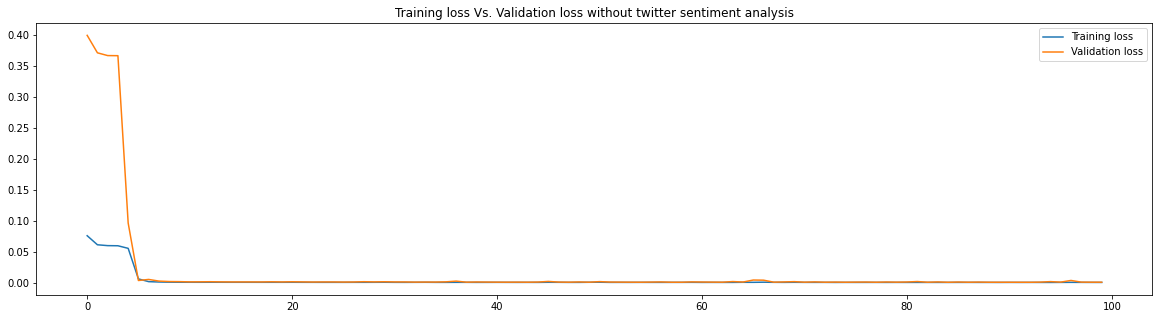

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()

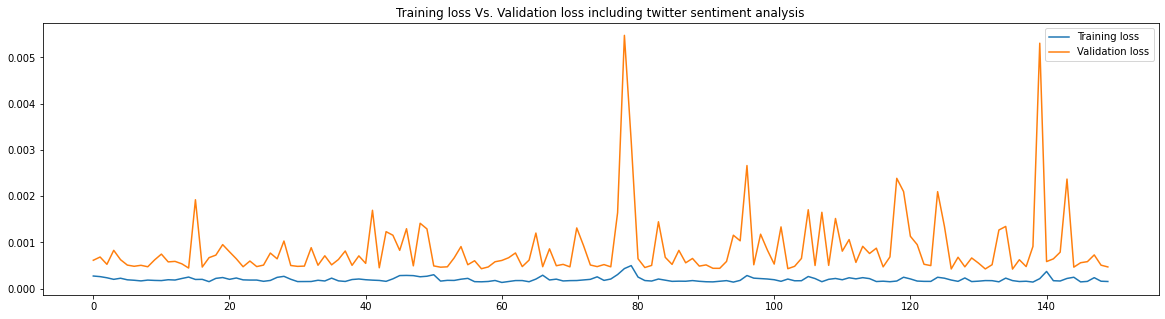

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
from sklearn.metrics import accuracy_score
a = 0
c = 0
def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()

        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        # acc=accuracy_score(y_actual_lstm[:,i], y_pred_lstm[:, i])
        # a += acc
        # c += 1
        print(f'Mean square error for {predicted_feature} ={error}')
    mse = mean_squared_error(y_actual_lstm, y_pred_lstm)
    print('Total mean square error', mse)
    print("RMSE :", sqrt(mse))
    # print('Accuracy', ((acc)/c)*100)

In [ ]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)
training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)
training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])
training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])
y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)
y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)
y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])
y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

28/28 [==============================] - 0s 13ms/step


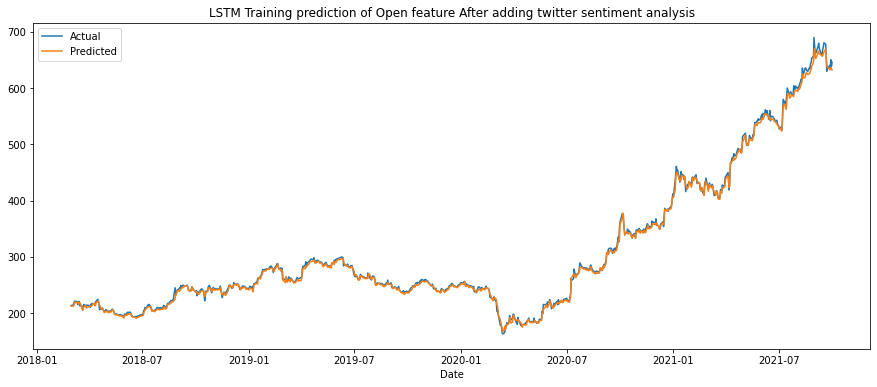

Mean square error for Open =21.592141994116425


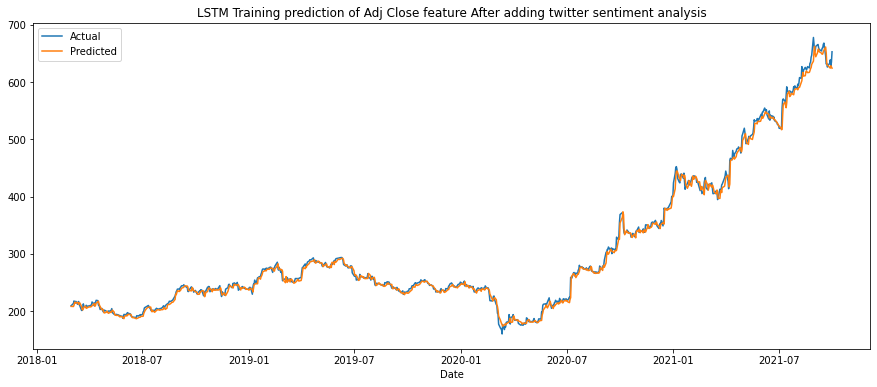

Mean square error for Adj Close =47.22817144568353
Total mean square error 34.41015671989997
RMSE : 5.866017108728884


In [ ]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

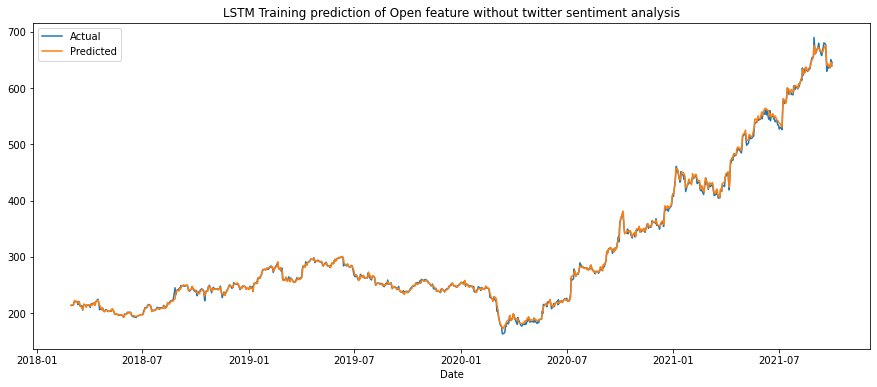

Mean square error for Open =12.819512413150697


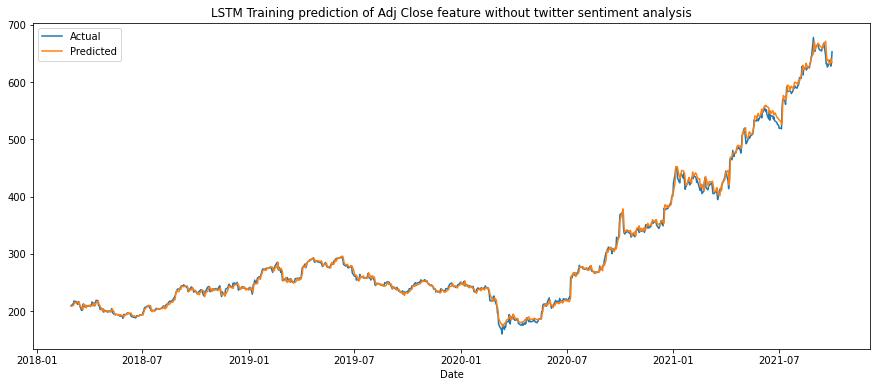

Mean square error for Adj Close =37.49111094048252
Total mean square error 25.155311676816613
RMSE : 5.015507120602723


In [ ]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_twitter)

In [ ]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

8/8 [==============================] - 0s 12ms/step


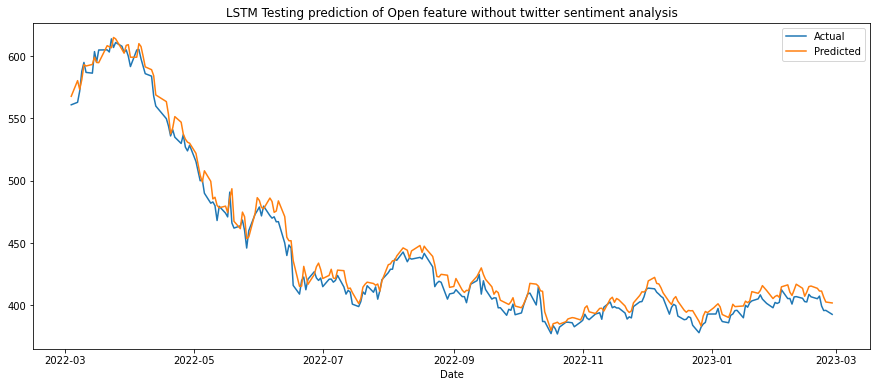

Mean square error for Open =63.294949807911735


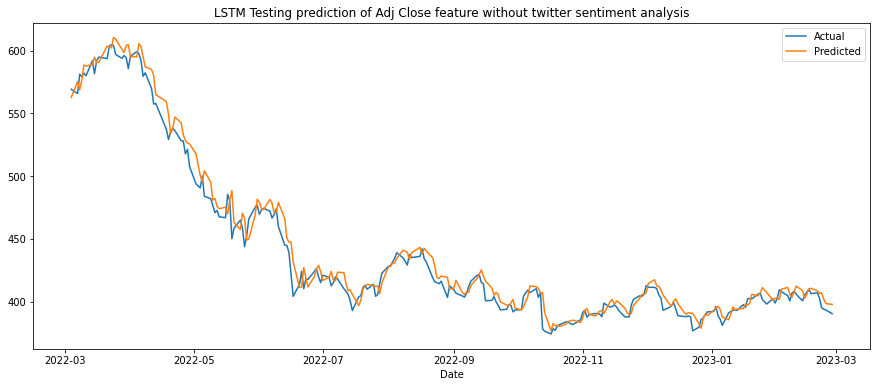

Mean square error for Adj Close =75.80985419441201
Total mean square error 69.5524020011619
RMSE : 8.33980827124712


In [ ]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

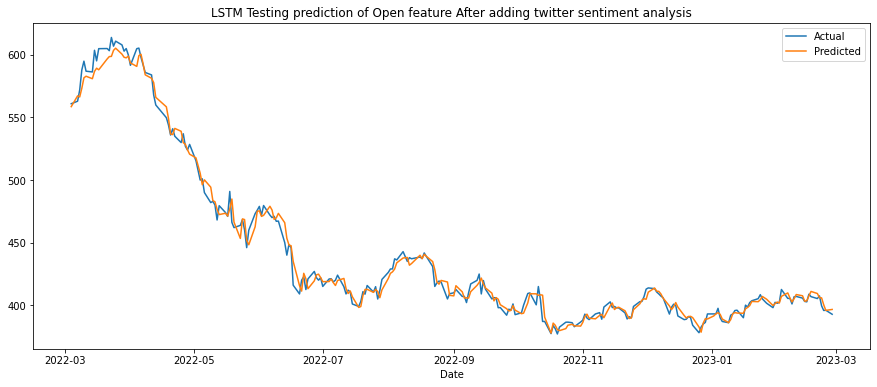

Mean square error for Open =33.03693078892926


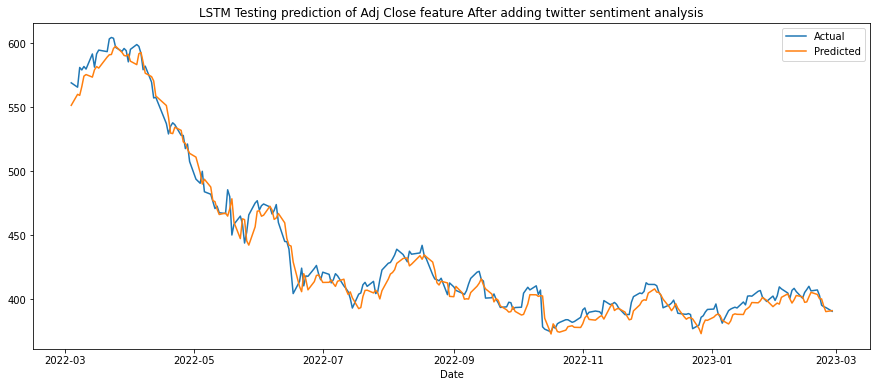

Mean square error for Adj Close =72.64763184008386
Total mean square error 52.842281314506565
RMSE : 7.269269654821354


In [ ]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

##Data

In [ ]:
data = pd.DataFrame(df_for_training, columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean', 'twt_count'])
data['Date'] = df['Date']

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.2)

In [ ]:
train_X_without_twitter = train[['Open', 'High', 'Low', 'Volume']]
train_y_without_twitter = train['Close']
test_X_without_twitter = test[['Open', 'High', 'Low', 'Volume']]
test_y_without_twitter = test['Close']

train_X_with_twitter = train[['Open', 'High', 'Low', 'Volume', 'P_mean']]
train_y_with_twitter = train['Close']
test_X_with_twitter = test[['Open', 'High', 'Low', 'Volume', 'P_mean']]
test_y_with_twitter = test['Close']

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [ ]:
RF_model1 = RandomForestClassifier()
RF_model2 = RandomForestClassifier()

In [ ]:
train_X_without_twitter = train_X_without_twitter.astype(int)
train_X_with_twitter = train_X_with_twitter.astype(int)
train_y_without_twitter = train_y_without_twitter.astype(int)
train_y_with_twitter = train_y_with_twitter.astype(int)

test_X_without_twitter = test_X_without_twitter.astype(int)
test_y_without_twitter = test_y_without_twitter.astype(int)
test_X_with_twitter = test_X_with_twitter.astype(int)
test_y_with_twitter = test_y_with_twitter.astype(int)

In [ ]:
RF_model1.fit(train_X_without_twitter, train_y_without_twitter)
RF_model2.fit(train_X_with_twitter, train_y_with_twitter)

RandomForestClassifier()

In [ ]:
prediction1 = RF_model1.predict(test_X_without_twitter)
prediction2 = RF_model2.predict(test_X_with_twitter)

RMSE value for Random Forest Model :  9.800437898173296


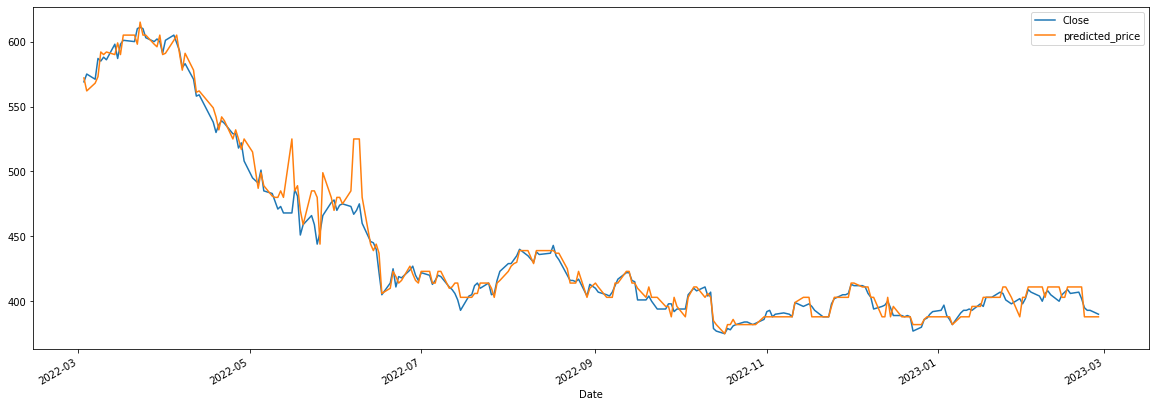

In [ ]:
predictions_df1 = pd.DataFrame(test_y_without_twitter)
predictions_df1['predicted_price'] = prediction1[0:]

predictions_df1.plot(figsize=(20,7))
rmse = sqrt(mean_squared_error(test_y_without_twitter, prediction1.flatten()))
print("RMSE value for Random Forest Model : ", rmse)

RMSE value for Random Forest Model :  6.426791090793006


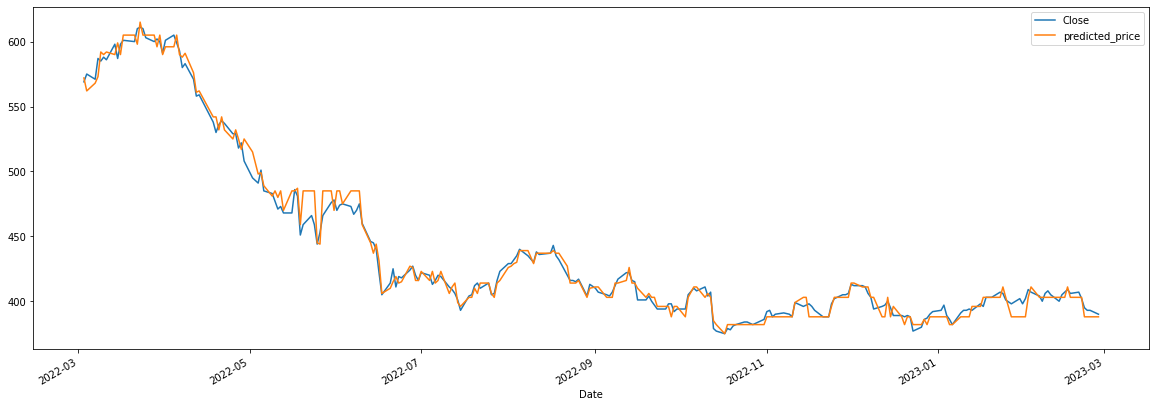

In [ ]:
predictions_df2 = pd.DataFrame(test_y_with_twitter)
predictions_df2['predicted_price'] = prediction2[0:]

predictions_df2.plot(figsize=(20,7))
rmse = sqrt(mean_squared_error(test_y_with_twitter, prediction2.flatten()))
print("RMSE value for Random Forest Model : ", rmse)

##XG Boost

In [ ]:
# Necessary imports
import numpy as np
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [ ]:


xgb_r1 = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)
xgb_r2 = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r1.fit(train_X_without_twitter, train_y_without_twitter.values.flatten())
xgb_r2.fit(train_X_with_twitter, train_y_with_twitter.values.flatten())
  
# Predict the model
pred1 = xgb_r1.predict(test_X_without_twitter)
pred2 = xgb_r2.predict(test_X_with_twitter)
  
# RMSE Computation
rmse1 = np.sqrt(MSE(test_y_without_twitter, pred1))
rmse2 = np.sqrt(MSE(test_y_with_twitter, pred2))
print("RMSE without twitter : % f" %(rmse1))
print("RMSE with twitter: % f" %(rmse2))

[10:00:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:00:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE without twitter :  18.284733
RMSE with twitter:  18.490840


##Support Vector Machine

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled

array([[0.10095604, 0.08658761, 0.10600083, ..., 0.09902019, 0.58441558,
        0.02463054],
       [0.10202815, 0.08612587, 0.10411437, ..., 0.09696126, 0.42857143,
        0.01970443],
       [0.09887886, 0.08375119, 0.09919611, ..., 0.09164802, 0.51020408,
        0.01477833],
       ...,
       [0.41579556, 0.39991208, 0.42040963, ..., 0.42335041, 0.29251701,
        0.15270936],
       [0.41606363, 0.39604223, 0.41888249, ..., 0.42217418, 0.42857143,
        0.06896552],
       [0.41034575, 0.39041336, 0.40612651, ..., 0.41683612, 0.45974026,
        0.13300493]])

In [ ]:
data1 = pd.DataFrame(df_for_training_scaled, columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean', 'twt_count'])

In [ ]:
data1

,Open,High,Low,Close,Volume,Adj Close,P_mean,twt_count
0,0.100956,0.086588,0.106001,0.101985,0.040388,0.099020,0.584416,0.024631
1,0.102028,0.086126,0.104114,0.099906,0.036936,0.096961,0.428571,0.019704
2,0.098879,0.083751,0.099196,0.094541,0.046952,0.091648,0.510204,0.014778
3,0.095127,0.082300,0.096703,0.092395,0.017239,0.089523,0.657143,0.009852
4,0.092446,0.078210,0.095154,0.092194,0.019232,0.089323,1.000000,0.002463
...,...,...,...,...,...,...,...,...
1228,0.436523,0.416271,0.436040,0.429938,0.020668,0.439274,0.284144,0.445813
1229,0.422407,0.402814,0.422296,0.416346,0.024978,0.425522,0.292740,0.298030
1230,0.415796,0.399912,0.420410,0.414200,0.021886,0.423350,0.292517,0.152709
1231,0.416064,0.396042,0.418882,0.413038,0.018154,0.422174,0.428571,0.068966


In [ ]:
train, test = train_test_split(data1, shuffle=False, test_size=0.2)

In [ ]:
train_X_without_twitter = train[['Open', 'High', 'Low', 'Volume']]
train_y_without_twitter = train['Close']
test_X_without_twitter = test[['Open', 'High', 'Low', 'Volume']]
test_y_without_twitter = test['Close']

train_X_with_twitter = train[['Open', 'High', 'Low', 'Volume', 'P_mean']]
train_y_with_twitter = train['Close']
test_X_with_twitter = test[['Open', 'High', 'Low', 'Volume', 'P_mean']]
test_y_with_twitter = test['Close']

In [ ]:
df_for_training['Close'].min()

162.35000610351562

In [ ]:
df_for_training['Close'].max()

721.5

In [ ]:
from sklearn import svm
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
svr_rbf1 = SVR(kernel='rbf', C=1, gamma=0.0001)
svr_rbf2 = SVR(kernel='rbf', C=1, gamma=0.0001)

svr_rbf1.fit(train_X_without_twitter.values, train_y_without_twitter.values)
svr_rbf2.fit(train_X_with_twitter.values, train_y_with_twitter.values)

output_test_svm1 = svr_rbf1.predict(test_X_without_twitter)
output_test_svm2 = svr_rbf2.predict(test_X_with_twitter)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [ ]:
actual = pd.DataFrame(test_y_without_twitter)

In [ ]:
scaler = MinMaxScaler(feature_range=(162, 721))
scaler = scaler.fit(actual)
actual1 = scaler.transform(actual)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(actual)

actual1

array([[622.38770417],
       [636.00163859],
       [627.83324904],
       [664.76853174],
       [660.15160334],
       [666.66261545],
       [661.80898078],
       [690.10231687],
       [665.36044193],
       [690.33902314],
       [697.32359231],
       [694.48239449],
       [718.27715531],
       [721.        ],
       [719.4609757 ],
       [702.41393326],
       [694.95595154],
       [700.40149641],
       [696.3764782 ],
       [675.30456206],
       [698.74411897],
       [707.74112499],
       [692.46995764],
       [679.21108262],
       [649.14201596],
       [655.77152572],
       [626.05751846],
       [596.69885963],
       [597.88268001],
       [549.10919347],
       [529.81300791],
       [544.13720566],
       [550.52986464],
       [546.97840348],
       [527.20851636],
       [526.97181008],
       [502.58513906],
       [511.10858803],
       [478.55352746],
       [445.88011375],
       [438.18528125],
       [460.44109002],
       [422.44048458],
       [417

In [ ]:
predicted = pd.DataFrame(output_test_svm1)

In [ ]:
scaler = MinMaxScaler(feature_range=(162, 721))
scaler = scaler.fit(predicted)
predicted1 = scaler.transform(predicted)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(predicted)

predicted1

array([[614.05606164],
       [610.7346312 ],
       [617.8831209 ],
       [641.5699465 ],
       [666.96023248],
       [673.68133432],
       [659.75414812],
       [671.16883759],
       [685.70646771],
       [681.87040785],
       [704.48990055],
       [707.52054629],
       [700.79476557],
       [721.        ],
       [712.58932859],
       [709.62946223],
       [703.16262486],
       [697.72153618],
       [703.4756665 ],
       [687.21850573],
       [679.27369908],
       [700.02558414],
       [702.44426189],
       [681.38755221],
       [662.08322961],
       [654.95332945],
       [642.36561389],
       [607.39336826],
       [597.1940933 ],
       [563.03039093],
       [546.43357557],
       [539.83442348],
       [550.67018437],
       [538.8491647 ],
       [521.37978418],
       [535.07149232],
       [509.60241708],
       [507.77489496],
       [506.93539095],
       [480.06225242],
       [450.08730014],
       [455.61446799],
       [425.60354289],
       [412

In [ ]:
actual = pd.DataFrame(test_y_with_twitter)

In [ ]:
scaler = MinMaxScaler(feature_range=(162, 721))
scaler = scaler.fit(actual)
actual2 = scaler.transform(actual)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(actual)

actual2

In [ ]:
predicted = pd.DataFrame(output_test_svm2)

In [ ]:
scaler = MinMaxScaler(feature_range=(162, 721))
scaler = scaler.fit(predicted)
predicted2 = scaler.transform(predicted)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(predicted)

predicted2

In [ ]:
rmse1 = np.sqrt(MSE(actual1, predicted1))
rmse2 = np.sqrt(MSE(actual2, predicted2))
print("RMSE without twitter : % f" %(rmse1))
print("RMSE with twitter: % f" %(rmse2))

RMSE without twitter :  9.567842
RMSE with twitter:  9.590257
